In [1]:
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u

import sys
sys.path.append('../')
import os
from src.classification import get_match_label_simple, get_match_label_advanced
from src.data import get_data_basic_matches
from sklearn.model_selection import train_test_split
from src.utils import transform_features, normalize_train_test

from joblib import load

In [3]:
df_all_model = pd.read_parquet('../scripts/nway_csc21_gaia3_full_neg_study_dis_niter200.parquet')

In [4]:
benchmark_ids = load('../scripts/jobs/models/neg_study_dis_niter200_withint_with_int_5X_lgbm_0-3_20241113_235113/benchmark_ids.joblib')

In [5]:
def get_train_val_test_splits(df_all_model, benchmark_ids, range_offaxis='0-3', separation=1.3):
   # get initial positives and split test set
   df_pos, _ = get_data_basic_matches(df_all_model, range_offaxis, separation)
   cscids = df_pos['csc21_name'].unique()
   cscids_train_val, cscids_test = train_test_split(cscids, test_size=0.2, random_state=42)
   
   # get train/val split from filtered train_val data
   df_train_val = df_all_model[df_all_model['csc21_name'].isin(cscids_train_val)]
   train_pos, _ = get_data_basic_matches(df_train_val, range_offaxis, separation)
   train_val_cscids = train_pos['csc21_name'].unique()
   cscids_train, cscids_val = train_test_split(train_val_cscids, test_size=0.2, random_state=42)
   
   assert set(benchmark_ids) == set(cscids_test)
   
   # get final datasets
   splits = {}
   for name, ids in [('train', cscids_train), ('val', cscids_val), ('test', cscids_test)]:
       data = df_all_model[df_all_model['csc21_name'].isin(ids)]
       pos, neg = get_data_basic_matches(data, range_offaxis, separation)
       splits[name] = {'pos': pos, 'neg': neg, 'full': data}
       
   return splits

splits = get_train_val_test_splits(df_all_model, benchmark_ids)

Range 0-3: 30279 positives, 310020 negatives
Range 0-3: 24223 positives, 245627 negatives
Range 0-3: 19378 positives, 195135 negatives
Range 0-3: 4845 positives, 50492 negatives
Range 0-3: 6056 positives, 64393 negatives


In [6]:
def validate_splits(splits, model_path):
   """validate train/val splits match saved model data"""
   
   # combine pos/neg sets
   val_data = splits['val']['full']
   train_data = splits['train']['full']
   
   # load saved validation data
   X_eval_saved = load(os.path.join(model_path, 'X_eval.joblib'))
   y_eval_saved = load(os.path.join(model_path, 'y_eval.joblib'))
   
   # prepare validation data
   val_data['eval_label'] = np.where(val_data['match_flag'] == 1, 1, 0)
   
   # preprocess
   X_train, _ = transform_features(train_data, log_transform=False, model_type='lgbm')
   X_val, cat_features = transform_features(val_data, log_transform=False, model_type='lgbm')
   _, X_val_norm, _ = normalize_train_test(X_train, X_val, method='none', 
                                         categorical_features=cat_features)
   
   # verify
   assert X_eval_saved.equals(X_val_norm)
   assert np.array_equal(y_eval_saved, val_data['eval_label'].values)
   
   return True

validate_splits(splits, '../scripts/jobs/models/neg_study_dis_niter200_withint_with_int_5X_lgbm_0-3_20241113_235113')

/tmp/ipykernel_1368105/694336655.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['eval_label'] = np.where(val_data['match_flag'] == 1, 1, 0)


True

In [7]:
# get the test data + everything from the dataset that was not in train and val
test_data = splits['test']['full']

# now get everything that was not in train and val
train_val_data = pd.concat([splits['train']['full'], splits['val']['full']])
train_val_ids = train_val_data['csc21_name'].unique()
not_train_val_data = df_all_model[~df_all_model['csc21_name'].isin(train_val_ids)].copy()

# check if test is IN not_train_val_data
assert set(test_data['csc21_name'].unique()) <= set(not_train_val_data['csc21_name'].unique())

In [8]:
val_data = splits['val']['full']

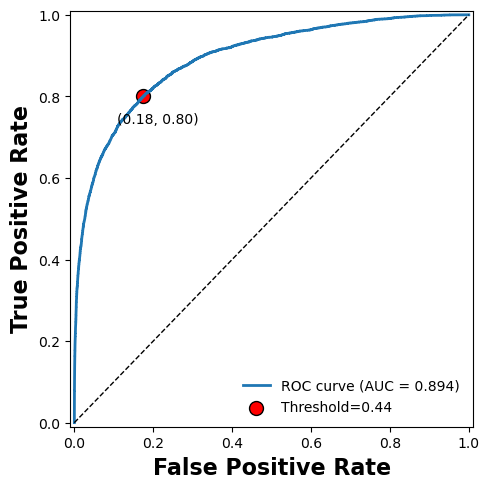

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# assume val_data is a pandas dataframe
# with columns "match_flag" (1 = positive class)
# and "p_match_ind" as probability estimates

# compute roc
fpr, tpr, thresholds = roc_curve(val_data['match_flag'] == 1, 
                                 val_data['p_match_ind'])
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
opt_thresh = thresholds[optimal_idx]
opt_idx = np.argmin(np.abs(thresholds - opt_thresh))

# create plot
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# highlight threshold
plt.scatter(fpr[opt_idx], tpr[opt_idx], s=100, edgecolor='k', 
            facecolor='red', label=f'Threshold={opt_thresh:.2f}')
plt.annotate(f'({fpr[opt_idx]:.2f}, {tpr[opt_idx]:.2f})',
             xy=(fpr[opt_idx], tpr[opt_idx]), 
             xytext=(10, -20),
             textcoords='offset points',
             ha='center', fontsize=10)

# styling
plt.xlabel('False Positive Rate', weight='bold', fontsize=16)
plt.ylabel('True Positive Rate', weight='bold', fontsize=16)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.legend(loc='lower right', frameon=False)
plt.tight_layout()


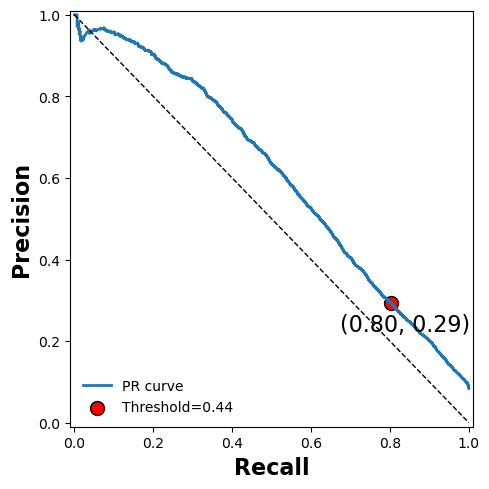

In [15]:
# now check the precision-recall curve
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(val_data['match_flag'] == 1,
                                                         val_data['p_match_ind'])

# create plot
plt.figure(figsize=(5, 5))
plt.plot(recall, precision, lw=2, label=f'PR curve')
plt.plot([0, 1], [1, 0], 'k--', lw=1)

# highlight threshold
fscore_idx = np.argmax(2 * precision * recall / (precision + recall))
opt_thresh = 0.44
opt_idx = np.argmin(np.abs(thresholds - opt_thresh))
plt.scatter(recall[opt_idx], precision[opt_idx], s=100, edgecolor='k', 
            facecolor='red', label=f'Threshold={opt_thresh:.2f}')
plt.annotate(f'({recall[opt_idx]:.2f}, {precision[opt_idx]:.2f})',
             xy=(recall[opt_idx], precision[opt_idx]), 
             xytext=(10, -20),
             textcoords='offset points',
             ha='center', fontsize=16)

# styling
plt.xlabel('Recall', weight='bold', fontsize=16)
plt.ylabel('Precision', weight='bold', fontsize=16)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.legend(loc='lower left', frameon=False)
plt.tight_layout()
plt.show()

Best threshold on validation (F1-based): 0.152, F1=0.928


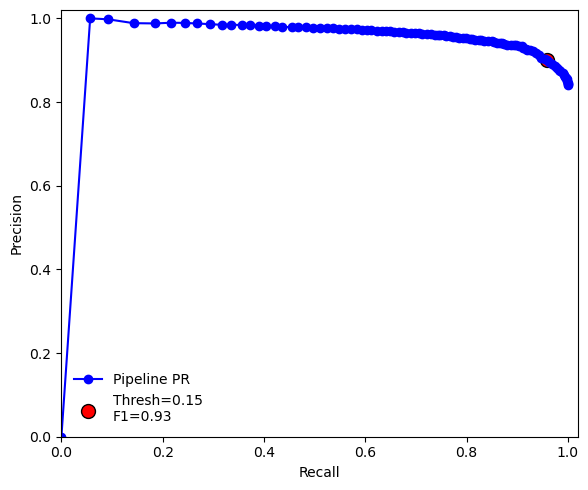

Best threshold on validation (F1-based): 0.152, Precision=0.900, Recall=0.959


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, precision_score, recall_score

# Assume:
#   - val_data is a validation dataframe with ground-truth labels in 'eval_label' (1=match, 0=no match).
#   - test_data is a test dataframe with 'eval_label' as well.
#   - Both dataframes have columns: 
#       'min_theta_mean' (off-axis),
#       'separation' (arcsec),
#       'p_match_ind' (ML score), etc.
#
# Also assume get_match_label_advanced(df, p_threshold) is already implemented
#   and returns a copy of df with a new column 'label' where label=1 if passing
#   (positional filter) & (p_threshold), else 0.

# ---------------------------
# 1) Sweep thresholds on validation set
# ---------------------------
thresholds = np.linspace(0.0, 1.0, 100)  # e.g. 51 points from 0.0 to 1.0
best_f1 = -1
best_thresh = 0.0

prec_vals, rec_vals, f1_vals = [], [], []

for t in thresholds:
    val_temp = get_match_label_advanced(val_data, p_threshold=t)
    y_true = val_temp['eval_label'].values
    y_pred = val_temp['label'].values
    
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    if prec+rec > 0:
        f1   = 2.0 * prec * rec / (prec + rec)
    else:
        f1 = 0.0

    prec_vals.append(prec)
    rec_vals.append(rec)
    f1_vals.append(f1)

    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best threshold on validation (F1-based): {best_thresh:.3f}, F1={best_f1:.3f}")

# ---------------------------
# 2) Plot precision-recall curve from our pipeline
#    (NOT just the raw ML score alone)
# ---------------------------


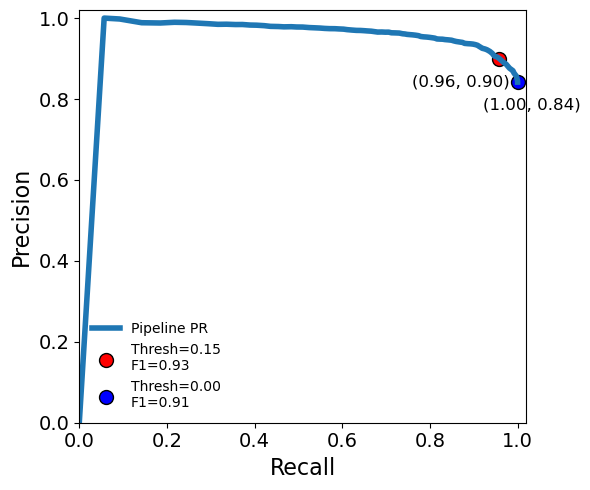

Best threshold on validation (F1-based): 0.152, Precision=0.900, Recall=0.959


In [36]:
plt.figure(figsize=(6,5))
plt.plot(rec_vals, prec_vals, label='Pipeline PR', linewidth=4)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.xlim([0,1.02])
plt.ylim([0,1.02])

# highlight best threshold
best_idx = np.argmax(f1_vals)
plt.scatter(rec_vals[best_idx], prec_vals[best_idx], s=100,
            facecolor='red', edgecolor='k',
            label=f'Thresh={thresholds[best_idx]:.2f}\nF1={f1_vals[best_idx]:.2f}')

#annotate precision and recall

plt.annotate(f'({rec_vals[best_idx]:.2f}, {prec_vals[best_idx]:.2f})',

                xy=(rec_vals[best_idx] -0.12, prec_vals[best_idx]),
                xytext=(10, -20),
                textcoords='offset points',
                ha='center', fontsize=12)

# annotate case with trs = 0 

zero_thresh_idx = np.argmin(np.abs(thresholds - 0))
plt.scatter(rec_vals[zero_thresh_idx], prec_vals[zero_thresh_idx], s=100,
            facecolor='blue', edgecolor='k',
            label=f'Thresh=0.00\nF1={f1_vals[zero_thresh_idx]:.2f}')
plt.annotate(f'({rec_vals[zero_thresh_idx]:.2f}, {prec_vals[zero_thresh_idx]:.2f})',
             xy=(rec_vals[zero_thresh_idx], prec_vals[zero_thresh_idx]),
             xytext=(10, -20),
             textcoords='offset points',
             ha='center', fontsize=12)

# tick labels and axis bigger
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.legend(loc='lower left', frameon=False)
plt.tight_layout()
plt.show()

print(f"Best threshold on validation (F1-based): {best_thresh:.3f}, Precision={prec_vals[best_idx]:.3f}, Recall={rec_vals[best_idx]:.3f}")